# 2023-06-23__Vm_traces_AdEx_Izh__Brian

In [1]:
from brian2 import *

In [2]:
defaultclock.dt

100. * usecond

In [3]:
# AdEx LIF neuron params (cortical RS from Naud 2008)
C   = 104  * pF
g_L = 4.3  * nS
E_L = -65  * mV
V_T = -52  * mV
Δ_T = 0.8  * mV 
Vs  =  40  * mV
Vr  = -53  * mV
a   = 0.8  * nS
b   =  65  * pA
tau_w =  88  * ms

88. * msecond

In [4]:
from scipy.special import lambertw

In [5]:
E_T = E_L - Δ_T * real(lambertw(-exp((E_L-V_T)/Δ_T), -1))

-49.63585597 * mvolt

In [6]:
k = g_L / (E_T - E_L)

2.79872409e-07 * metre ** -4 * kilogram ** -2 * second ** 6 * amp ** 3

In [10]:
E_e = 0   * mV
E_i = -80 * mV
we = 8    * nS
wi = 8    * nS
tau = 7   * ms;

Input neurons:

In [63]:
N = 6500
# N = 500

μₓ = 4 # Hz
σ = sqrt(0.6)
μ = log(μₓ) - σ**2 / 2

1.0862943611198905

In [64]:
Ne = N * 4//5

5200

In [65]:
izh = "dV/dt = ( k*(V - E_L)*(V - E_T) -I -w) / C : volt"
adx = "dV/dt = ( -g_L*(V - E_L) + g_L * Δ_T * exp((V-V_T)/Δ_T) -I ) / C : volt"

eqs = lambda F: f"""
{F}
dw/dt = (a*(V - E_L) - w) / tau_w : amp

I = g_e * (V - E_e) + g_i * (V - E_i) : amp

dg_e/dt = -g_e / tau : siemens
dg_i/dt = -g_i / tau : siemens
"""

def network(F):
    n = NeuronGroup(1, eqs(izh), threshold="V > Vs", reset="V = Vr; w += b", method='euler')
    n.V = Vᵣ
    n.w = 0 * nA
    n.g_e = 0 * nS
    n.g_i = 0 * nS
    
    rates = lognormal(μ, σ, N) * Hz;
    P = PoissonGroup(N, rates)
    
    Se = Synapses(P, n, on_pre="g_e += we")
    Si = Synapses(P, n, on_pre="g_i += wi")
    Se.connect("i < Ne")
    Si.connect("i >= Ne")
    
    M = StateMonitor(n, ["V", "I", "w"], record=0)
    
    objs = [n, P, Se, Si, M]
    return *objs, Network(objs)

In [66]:
n, P, Se, Si, M, net = network(izh)

In [67]:
n

NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_5')

In [68]:
net.store()

In [85]:
net.restore()

we = 0.02   * nS
wi = 0.08   * nS

net.run(1000 * ms, report='text')

Starting simulation at t=0. s for a duration of 1. s
1. s (100%) simulated in 1s


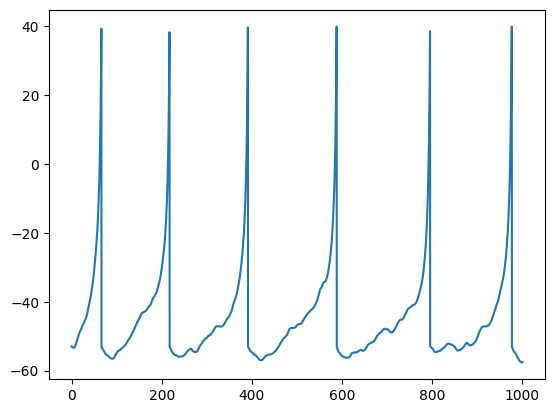

In [86]:
plot(M.t / ms, M.V[0] / mV);